# Creating a Kaggle Workflow


## Introducing Data Science Workflows

We're going to explore a workflow to make competing in the [Kaggle Titanic competition](https://www.kaggle.com/c/titanic/overview) easier, using a pipeline of functions to reduce the number of dimensions we need to focus on.

The goal of this project is to create a data science workflow for Kaggle Titanic competition.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

pd.options.display.max_columns = 999

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train.csv")

holdout = pd.read_csv("test.csv")
holdout.head(10)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


## Preprocessing the Data


In [3]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

Let's create a new function that:
- Applies the process_missing(), process_age(), process_fare(), process_titles(), and process_cabin() functions to the dataframe;
- Applies the create_dummies() function to the "Age_categories", "Fare_categories","Title", "Cabin_type", and "Sex" columns;
- And returns the processed dataframe.

In [4]:
def general_function(df,list_columns):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    for column in list_columns:
        df = create_dummies(df,column)
        
    return df

In [5]:
list_columns = ["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"]

train = general_function(train, list_columns)

In [6]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_categories,Fare_categories,Title,Cabin_type,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Fare_categories_0-12,Fare_categories_12-50,Fare_categories_50-100,Fare_categories_100+,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Young Adult,0-12,Mr,Unknown,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Adult,50-100,Mrs,C,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Young Adult,0-12,Miss,Unknown,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Young Adult,50-100,Mrs,C,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Young Adult,0-12,Mr,Unknown,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
5,6,0,3,"Moran, Mr. James",male,-0.5,0,0,330877,8.4583,Q,Missing,0-12,Mr,Unknown,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S,Adult,50-100,Mr,E,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S,Infant,12-50,Master,Unknown,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S,Young Adult,0-12,Mrs,Unknown,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C,Teenager,12-50,Mrs,Unknown,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0


In [7]:
holdout = general_function(holdout, list_columns)
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_categories,Fare_categories,Title,Cabin_type,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Fare_categories_0-12,Fare_categories_12-50,Fare_categories_50-100,Fare_categories_100+,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_Unknown,Sex_female,Sex_male
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,Young Adult,0-12,Mr,Unknown,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,Adult,0-12,Mrs,Unknown,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,Senior,0-12,Mr,Unknown,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,Young Adult,0-12,Mr,Unknown,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,Young Adult,12-50,Mrs,Unknown,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0


## Exploring the Data

In [8]:
# inspect the type of the columns

explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SibSp     891 non-null    int64
 1   Parch     891 non-null    int64
 2   Survived  891 non-null    int64
dtypes: int64(3)
memory usage: 21.0 KB


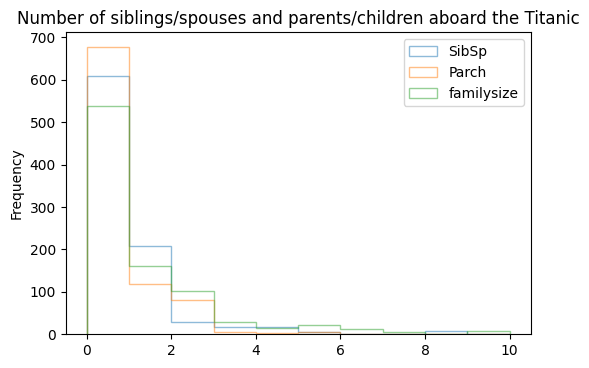

In [9]:
# let's use histograms to view the distribution of values in the columns

explore["familysize"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.drop("Survived",axis=1).plot.hist(histtype='step', alpha=0.5,bins=10)
plt.title("Number of siblings/spouses and parents/children aboard the Titanic")
plt.show()

As we see most of the people do not have any relativies.

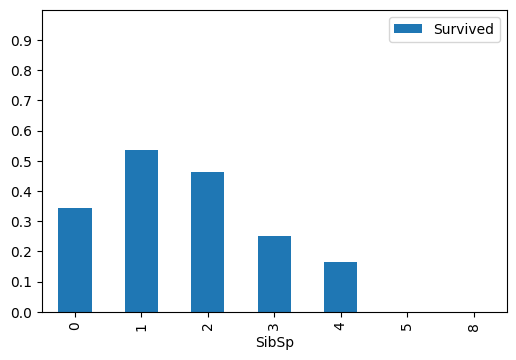

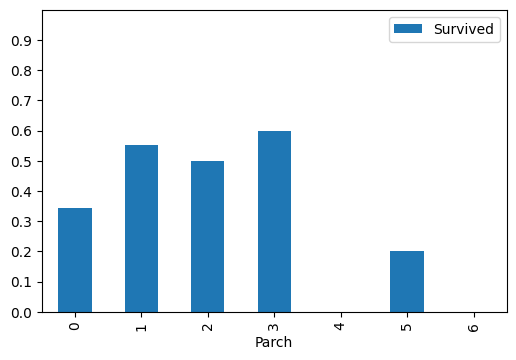

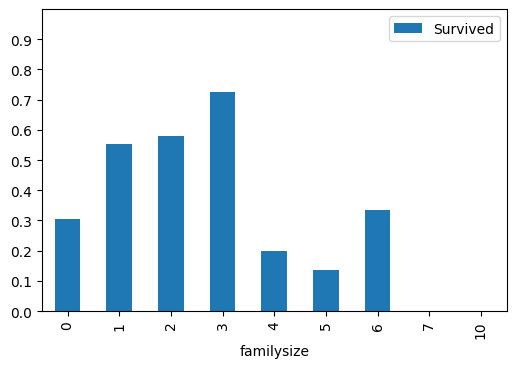

In [10]:
# let's use pivot tables to look at the survival rate for different values of the columns

for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.show()

We found outthat by combining the values of 'SibSp' and 'Parch' into a single column, only 30% of the passengers who had no family members onboard survived.

## Engineering New Features

Based of previous conclusion, we can come up with an idea for a new feature - was the passenger alone. This will be a binary column containing the value:
- 1 if the passenger has zero family members onboard;
- 0 if the passenger has one or more family members onboard.

Let's create a new function that:
- Accepts a dataframe as input;
- Adds a new column, isalone that has the value 0 if the passenger has one or more family members onboard, and 1 if the passenger has zero family members onboard;
- Returns the new dataframe.


In [11]:
def fam_member(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df["isalone"] = df["familysize"].apply(lambda x: 1 if x == 0 else 0)
    return df

In [12]:
train = fam_member(train)
holdout_new = fam_member(holdout)

train[["familysize", "isalone"]].head(10)

,familysize,isalone
0,1,0
1,1,0
2,0,1
3,1,0
4,0,1
5,0,1
6,0,1
7,4,0
8,2,0
9,1,0


In [13]:
train["isalone"].value_counts()

1    537
0    354
Name: isalone, dtype: int64

## Selecting the Best-Performing Features

Let's write a function that:

- Accepts a dataframe as input;
- Performs data preparation for machine learning;
- Uses recursive feature elimination and the random forests algorithm to find the best-performing set of features.


In [14]:
def select_features(df):
    clf = RandomForestClassifier(random_state=1)
      
    df = df.select_dtypes([np.number]).dropna(axis=1, how='any') 
    all_X = df.drop(["PassengerId", "Survived"], axis=1)
    all_y = df["Survived"]
    
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    optimized_columns = list(all_X.columns[selector.support_])
    print("The best columns are:\n", optimized_columns)  
    return optimized_columns


In [15]:
best_cols = select_features(train)

The best columns are:
 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'familysize']


As we see this results have a high level of multicollinearity e.g. "Title_Miss", "Title_Mr", "Title_Mrs", "Sex_female", "Sex_male". So let's use just any one single column: "Sex_female" or "Sex_male", or another one.

In [16]:
#remove "Title_Miss", "Title_Mr", "Title_Mrs", "Sex_male"

best_cols = ["Pclass", "Age", "SibSp", "Parch", "Fare", "Age_categories_Missing", 
             "Age_categories_Infant", "Age_categories_Young Adult", "Age_categories_Adult", 
             "Fare_categories_0-12", "Fare_categories_12-50", "Fare_categories_50-100", 
             "Title_Master", "Cabin_type_E", "Cabin_type_Unknown", "Sex_female", "familysize"]



## Selecting and Tuning Different Algorithms

Next we'll create three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

In [17]:
def select_model(df, features_list):
    all_X = df[features_list]
    all_y = df["Survived"]
    list_models = [
    {
        "name": "LogisticRegression",
        "estimator": LogisticRegression(),
        "hyperparameters":
            {  
            "solver": ["newton-cg", "lbfgs", "liblinear"]
            }
    },
    {
        "name": "KNeighborsClassifier",
        "estimator": KNeighborsClassifier(),
        "hyperparameters":
            {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
        }
    },
    {
         "name": "RandomForestClassifier",
         "estimator": RandomForestClassifier(),
         "hyperparameters":
             {
            "n_estimators": [4, 6, 9],
            "criterion": ["entropy", "gini"],
            "max_depth": [2, 5, 10],
            "max_features": ["log2", "sqrt"],
            "min_samples_leaf": [1, 5, 8],
            "min_samples_split": [2, 3, 5]
        }
    }   
    ]
    
    for model in list_models:
        print(model["name"])
        print('---------------------')
        grid = GridSearchCV(model["estimator"], param_grid=model["hyperparameters"], cv=10)
        grid.fit(all_X, all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_estimator"] = grid.best_estimator_
        
        print("The best score: {}".format(model["best_score"]))
        print("The best parameters: {}\n".format(model["best_params"]))
       
    return list_models

In [18]:
best_model = select_model(train, best_cols)

LogisticRegression
---------------------
The best score: 0.8148689138576779
The best parameters: {'solver': 'liblinear'}

KNeighborsClassifier
---------------------
The best score: 0.7598876404494381
The best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 19, 'p': 1, 'weights': 'distance'}

RandomForestClassifier
---------------------
The best score: 0.8351061173533084
The best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 6}



As we see the RandomForestClassifier is the best model for our data. Next let's predict the result.

## Making a Submission to Kaggle

In [19]:
def save_submission_file(model, cols, filename="submission.csv"):
    holdout_data = holdout_new[cols]
    holdout_predictions = model.predict(holdout_data)
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                     "Survived": holdout_predictions}
    submission = pd.DataFrame(submission_df)

    return submission.to_csv(filename,index=False)   

In [20]:
# choose the best model from previous step

select_best_model = best_model[2]["best_estimator"]


# Use save_submission_file() to save out a CSV of predictions

save_submission_file(select_best_model, best_cols)

## Conclusion

In this guided project, we created a reproducible workflow to help us iterate over ideas and continue to improve the accuracy of our predictions. We also created helper functions which will make feature selection, model selection/tuning and creating submissions much easier as we continue to explore the data and create new features.

### Next steps:

Here are some suggestions of next steps:

- Use some different algorithms in the select_model() function, like support vector machines, stochastic gradient descent or perceptron linear models.
- Experiment with RandomizedSearchCV instead of GridSearchCV to speed up our select_features() function.
